In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from datasets import load_dataset
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import librosa
torch.manual_seed(42)

In [2]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

def plot_confusion_matrix(confusion_matrix, labels):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(confusion_matrix, cmap="gray")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")
    plt.show(block=False)

In [3]:
def count_label(dataset):
    label_count = {}
    for label in dataset['labels']:
        if label in label_count:
            label_count[label] += 1
        else:
            label_count[label] = 1
    return label_count

def load_dataset(path):
    file_limit_per_class = 10000
    # Create empty lists to store waveforms, sample rates and labels
    dataset = {'waveforms': [], 'sample_rates': [], 'labels': []}
    print("number of label:",len(os.listdir(path)))
    # Loop over the sub-folders in the root folder
    for folder in os.listdir(path):
        # Get the label from the folder name
        label = folder
        counter = 0
        # Loop over the audio files in each sub-folder
        for filename in glob.glob(os.path.join(path, folder, '*.wav')):
            counter += 1
            try:
                # Load an audio file as a tensor and its sample rate
                waveform, sample_rate = torchaudio.load(filename)
                if waveform.shape[1] < 86400:
                    continue
                # Append them to the lists
                dataset['waveforms'].append(waveform)
                dataset['sample_rates'].append(sample_rate)
                dataset['labels'].append(label)
                # Stop if we have enough audio files
                if counter >= file_limit_per_class:
                    break
            except Exception as e:
                pass
    return dataset

In [4]:
""" train = load_dataset('..\\..\\..\\sound-propagation-simulation\\dataset\\train\\2023-04-19 09-34-19-train')
print("train dataset loaded, size:",len(train['waveforms']))
print(count_label(train)) 
test = load_dataset('..\\..\\..\\sound-propagation-simulation\\dataset\\test\\2023-04-19 10-24-13-test')
print("test dataset loaded, size:",len(test['waveforms']))
print(count_label(test)) """

train = load_dataset('..\\..\\..\\sound-propagation-simulation\\dataset_real_data\\train\\2023-04-19 09-34-19-train')
print("train dataset loaded, size:",len(train['waveforms']))
print(count_label(train)) 
test = load_dataset('..\\..\\..\\sound-propagation-simulation\\dataset_real_data\\test\\2023-04-19 10-24-13-test')
print("test dataset loaded, size:",len(test['waveforms']))
print(count_label(test))

number of label: 2
train dataset loaded, size: 288
{'StartPoint2_StartPoint5': 145, 'StartPoint5_StartPoint2': 143}
number of label: 2
test dataset loaded, size: 111
{'StartPoint2_StartPoint5': 46, 'StartPoint5_StartPoint2': 65}


In [5]:
def crop_audio(waveforms):
    # append second channel after the end of first channel
    waveforms_cropped = [torch.cat((waveform, waveform), 1) for waveform in waveforms]
    # remove second channel
    waveforms_cropped = [waveform[0] for waveform in waveforms_cropped]
    return waveforms_cropped

train_waveforms = train['waveforms']
train_labels = train['labels']
test_waveforms = test['waveforms']
test_labels = test['labels']

train_waveforms_cropped = crop_audio(train_waveforms)
test_waveforms_cropped = crop_audio(test_waveforms)


In [7]:
# create tensors from the lists
train_waveforms_tensor = torch.stack(train_waveforms_cropped)
test_waveforms_tensor = torch.stack(test_waveforms_cropped)
print(train_waveforms_tensor.shape)
# convert the labels to integers
label_to_int = {label: i for i, label in enumerate(set(train_labels))}
train_int_labels = [label_to_int[label] for label in train_labels]
train_int_labels = torch.tensor(train_int_labels)
print(train_int_labels.shape)
test_int_labels = [label_to_int[label] for label in test_labels]
test_int_labels = torch.tensor(test_int_labels)
print(test_int_labels.shape)
# print number of classes
int_to_label = {i: label for label, i in label_to_int.items()}
# print labels with their corresponding integer
print(int_to_label)

torch.Size([288, 172800])
torch.Size([288])
torch.Size([111])
{0: 'StartPoint5_StartPoint2', 1: 'StartPoint2_StartPoint5'}


torch.Size([288, 501, 136])


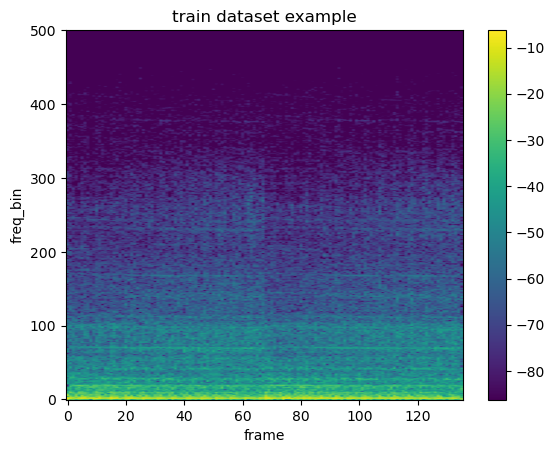

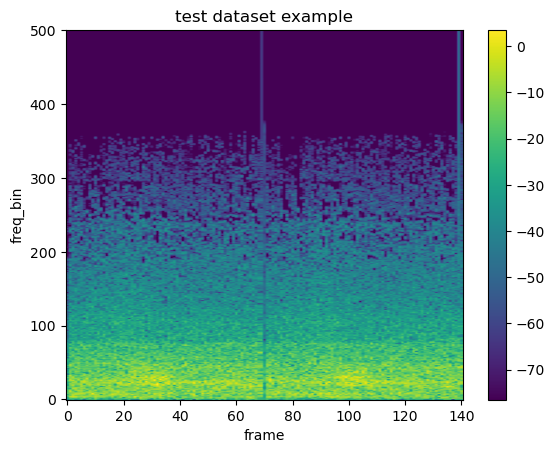

StartPoint2_StartPoint5
torch.Size([288, 1, 501, 136])
torch.Size([111, 1, 501, 141])


In [8]:
# convert the waveforms to log based spectrograms
train_spectrograms = [F.spectrogram(waveform, pad=0, window=torch.hann_window(1000), n_fft=1000, hop_length=1280, win_length=1000, power=2.0, normalized=True) for waveform in train_waveforms_tensor]
test_spectrograms = [F.spectrogram(waveform, pad=0, window=torch.hann_window(1000), n_fft=1000, hop_length=1280, win_length=1000, power=2.0, normalized=True) for waveform in test_waveforms_tensor]
train_spectrograms = torch.stack(train_spectrograms)
test_spectrograms = torch.stack(test_spectrograms)

# crop the spectrograms to remove high frequencies
# train_spectrograms = train_spectrograms[:, :200, :]
# test_spectrograms = test_spectrograms[:, :200, :]
print(train_spectrograms.shape)
idx=0
plot_spectrogram(train_spectrograms[idx], title="train dataset example")
plot_spectrogram(test_spectrograms[idx], title="test dataset example")
print(train_labels[idx])
# add a channel dimension
train_spectrograms = train_spectrograms.unsqueeze(1)
test_spectrograms = test_spectrograms.unsqueeze(1)
print(train_spectrograms.shape)
print(test_spectrograms.shape)

In [9]:
# dataloader
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_spectrograms, train_int_labels)
test_dataset = TensorDataset(test_spectrograms, test_int_labels)
# split the dataset into labels and features
X_train = train_dataset.tensors[0]
y_train = train_dataset.tensors[1]
X_test = test_dataset.tensors[0]
y_test = test_dataset.tensors[1]
print(X_train.shape)
print(X_test.shape)

torch.Size([288, 1, 501, 136])
torch.Size([111, 1, 501, 141])


In [10]:
import torch.nn as nn
from torchsummary import summary

import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(33728, len(set(train_labels)))
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization


model = CNN()
summary(model, X_train.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 250, 68]          --
|    └─Conv2d: 2-1                       [-1, 8, 501, 136]         208
|    └─ReLU: 2-2                         [-1, 8, 501, 136]         --
|    └─MaxPool2d: 2-3                    [-1, 8, 250, 68]          --
├─Sequential: 1-2                        [-1, 16, 125, 34]         --
|    └─Conv2d: 2-4                       [-1, 16, 250, 68]         3,216
|    └─ReLU: 2-5                         [-1, 16, 250, 68]         --
|    └─MaxPool2d: 2-6                    [-1, 16, 125, 34]         --
├─Sequential: 1-3                        [-1, 32, 62, 17]          --
|    └─Conv2d: 2-7                       [-1, 32, 125, 34]         12,832
|    └─ReLU: 2-8                         [-1, 32, 125, 34]         --
|    └─MaxPool2d: 2-9                    [-1, 32, 62, 17]          --
├─Linear: 1-4                            [-1, 2]                   67,458
Tot

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 250, 68]          --
|    └─Conv2d: 2-1                       [-1, 8, 501, 136]         208
|    └─ReLU: 2-2                         [-1, 8, 501, 136]         --
|    └─MaxPool2d: 2-3                    [-1, 8, 250, 68]          --
├─Sequential: 1-2                        [-1, 16, 125, 34]         --
|    └─Conv2d: 2-4                       [-1, 16, 250, 68]         3,216
|    └─ReLU: 2-5                         [-1, 16, 250, 68]         --
|    └─MaxPool2d: 2-6                    [-1, 16, 125, 34]         --
├─Sequential: 1-3                        [-1, 32, 62, 17]          --
|    └─Conv2d: 2-7                       [-1, 32, 125, 34]         12,832
|    └─ReLU: 2-8                         [-1, 32, 125, 34]         --
|    └─MaxPool2d: 2-9                    [-1, 32, 62, 17]          --
├─Linear: 1-4                            [-1, 2]                   67,458
Tot

In [11]:
from torch.utils.tensorboard import SummaryWriter
import datetime
import tqdm


In [12]:
time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter('runs_2/'+time)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(torch.cuda.get_device_name(0))

# Create a CNN model
model = CNN()
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Train the model
batch_size = 128
num_epochs = 20000
model.to(device)
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for i in range(0,len(train_loader), batch_size):
        with torch.set_grad_enabled(True):
            # Get the inputs and labels
            inputs, labels = next(iter(train_loader))
            # Forward pass
            outputs,x = model(inputs)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            with torch.no_grad():
                test_loss = 0
                correct = 0
                total = 0
                for i in range(0,len(test_loader), batch_size):
                    inputs, labels = next(iter(test_loader))
                    outputs, x = model(inputs)
                    test_loss += criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                writer.add_scalar('loss/train', loss.item(), epoch)
                writer.add_scalar('accuracy/test', 100 * correct / total, epoch)
                print('Epoch: {}, Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch+1, loss.item(), 100 * correct / total))
    if (epoch+1)%20000 == 0:
        print('Model saved to model_{}.ckpt'.format(epoch+1))
        torch.save(model.state_dict(), 'models/{}model_{}.ckpt'.format(time,epoch+1))

NVIDIA GeForce RTX 4070 Ti
Epoch: 10, Loss: 0.6932, Test Accuracy: 41.44%
Epoch: 20, Loss: 0.6703, Test Accuracy: 63.96%
Epoch: 30, Loss: 0.6739, Test Accuracy: 41.44%
Epoch: 40, Loss: 0.5519, Test Accuracy: 50.45%
Epoch: 50, Loss: 0.4370, Test Accuracy: 43.24%
Epoch: 60, Loss: 0.4852, Test Accuracy: 45.05%
Epoch: 70, Loss: 0.4613, Test Accuracy: 43.24%
Epoch: 80, Loss: 0.4304, Test Accuracy: 40.54%
Epoch: 90, Loss: 0.4567, Test Accuracy: 45.95%
Epoch: 100, Loss: 0.4723, Test Accuracy: 41.44%
Epoch: 110, Loss: 0.4835, Test Accuracy: 44.14%
Epoch: 120, Loss: 0.4410, Test Accuracy: 41.44%
Epoch: 130, Loss: 0.4441, Test Accuracy: 41.44%
Epoch: 140, Loss: 0.5009, Test Accuracy: 45.05%
Epoch: 150, Loss: 0.5493, Test Accuracy: 38.74%
Epoch: 160, Loss: 0.4574, Test Accuracy: 43.24%
Epoch: 170, Loss: 0.4808, Test Accuracy: 43.24%
Epoch: 180, Loss: 0.4620, Test Accuracy: 42.34%
Epoch: 190, Loss: 0.4454, Test Accuracy: 40.54%
Epoch: 200, Loss: 0.4477, Test Accuracy: 40.54%
Epoch: 210, Loss: 0.42

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs,x = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {:.2f} %'.format(100 * correct / total))


Test Accuracy of the model on the test images: 58.54 %


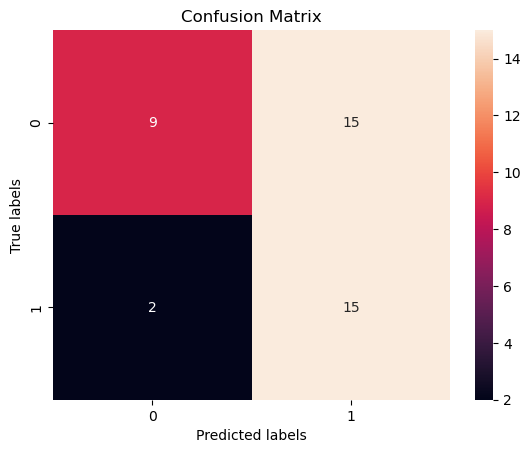

In [ ]:
# plot a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = []
y_true = []
for inputs, labels in test_loader:
    outputs = model(inputs)[0]
    _, predicted = torch.max(outputs.data, 1)
    for i in predicted:
        y_pred.append(i.cpu().numpy())
    for i in labels:
        y_true.append(i.cpu().numpy())
cm = confusion_matrix(y_true, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
# add the plot to tensorboard
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
writer.add_figure('Confusion Matrix', fig, global_step=0)

In [ ]:
# load a wav file to test the model
import torchaudio.functional as F
import os
validation_root = '../../../sound-propagation-simulation/dataset/validation/2023-04-18 13-23-21/'
waveforms = []
sample_rates = []
labels_validation = []
print(len(os.listdir(validation_root)))
# Loop over the sub-folders in the root folder
for folder in os.listdir(validation_root):
    # Get the label from the folder name
    label = folder
    # Loop over the audio files in each sub-folder
    for filename in glob.glob(os.path.join(validation_root, folder, '*.wav')):
        try:
            # Load an audio file as a tensor and its sample rate
            waveform, sample_rate = torchaudio.load(filename)
            # Append them to the lists
            # drop mono waveforms
            if waveform.shape[0] == 1:
                continue
            # drop samples < 86400
            if waveform.shape[1] < 86400:
                continue
            waveforms.append(waveform)
            sample_rates.append(sample_rate)
            labels_validation.append(label)
        except Exception as e:
            print(e)
print("keeping",len(waveforms), "files")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../../sound-propagation-simulation/dataset/validation/2023-04-18 13-23-21/'

In [ ]:
print("labels:",set(labels_validation))
# crop every waveform to 86400 samples
waveforms=[waveform[:,0:86400] for waveform in waveforms]
# print the number of waveforms
print("number of waveforms:",len(waveforms))
# test if all waveforms have same number of channels
waveforms = [waveform for waveform in waveforms if waveform.shape[0] == 2]
print("number of waveforms with 2 channels:",len(waveforms))
# put the second channel after the first one
waveforms = crop_audio(waveforms)
print(waveforms[0].shape)
prepared_waveforms = torch.stack(waveforms)
print(prepared_waveforms.shape)

labels: {'StartPoint1_StartPoint2', 'StartPoint6_StartPoint5', 'StartPoint2_StartPoint5', 'StartPoint2_StartPoint1', 'StartPoint5_StartPoint2', 'StartPoint5_StartPoint6'}
number of waveforms: 544
number of waveforms with 2 channels: 544
torch.Size([172800])
torch.Size([544, 172800])


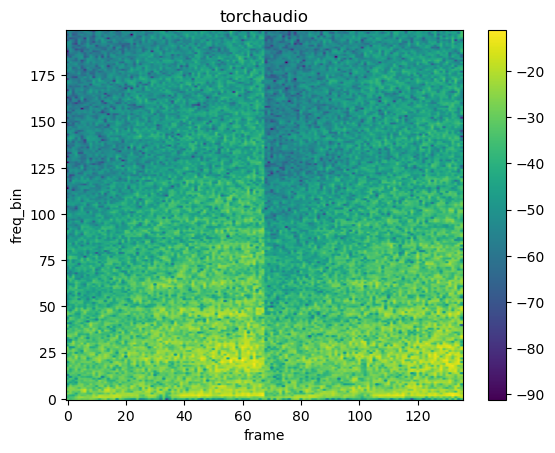

200px height spectrogram shape torch.Size([544, 200, 136])
spectrogram shape torch.Size([544, 1, 200, 136])


In [ ]:
# log based spectrogram
spectrograms = F.spectrogram(prepared_waveforms, pad=0, window=torch.hann_window(1000), n_fft=1000, hop_length=1280, win_length=1000, power=2.0, normalized=True)
# crop the spectrograms to remove high frequencies
spectrograms = spectrograms[:,:200, :]
# plot the spectrogram (log scale)
plot_spectrogram(spectrograms[idx], title="torchaudio")

print("200px height spectrogram shape",spectrograms.shape)
spectrograms = spectrograms.unsqueeze(1)
print("spectrogram shape",spectrograms.shape)
# predict the class of the loaded spectrogram





In [ ]:
model.to('cpu')
outputs = model(spectrograms)
predicted = outputs[0].data
# print each label with its corresponding probability in percentage
outputs = torch.nn.Softmax(dim=1)(outputs[0])
outputs = outputs * 100
outputs = torch.round(outputs)
#print(outputs)
#print("predicted class:",predicted.argmax(1))
# make the label_to_int dictionary based on the int_to_label dictionary
print("int_to_label:",int_to_label)
label_to_int = {v: k for k, v in int_to_label.items()}
print("label_to_int:",label_to_int)
# map the true class to the integer value following the label_to_int dictionary
true_class = [label_to_int[label] for label in labels_validation]
print("true class:",true_class)
# map the predicted class to the integer value following the label_to_int dictionary
predicted_class = list(predicted.argmax(1).numpy())
print("predicted class:",predicted_class)
# compute the accuracy
accuracy = (predicted.argmax(1) == torch.tensor(true_class)).sum().item() / len(true_class) * 100
print("accuracy:",accuracy)
# plot a confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(true_class, predicted_class)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()




RuntimeError: mat1 and mat2 shapes cannot be multiplied (544x13600 and 33728x6)